# Comparison between the recommender systems

This notebook compares the different recommender systems implemented in this project. In the first experiment we compare
the different models using the Movielens 100K dataset. In the second experiment we try to determine the scalability of
the different models using randomly generated data and plotting the time it takes to train the model.

Copyright 2023 Bernardo C. Rodrigues

See COPYING file for license details

In [1]:
# Load the autoreload extension
%load_ext autoreload

# Set autoreload to reload all modules every time a cell is executed
%autoreload 2

In [2]:
# Customize plotly's template
import plotly.io as pio
import plotly.graph_objects as go


DPI = 300
WIDTH = 1200
HEIGHT = 800
FORMAT = "png"


def customize_default_template():
    """
    Customize the default template with specific layout settings.

    This function modifies the default template provided by Plotly with customizations
    to the font, margin, width, background color, y-axis, x-axis, and legend.

    The modified template is then set as the default template for all subsequent figures.

    Returns:
        None
    """

    # Access the default template
    default_template = pio.templates[pio.templates.default]

    # Customize font settings
    default_template.layout.font.family = "Latin Modern"
    default_template.layout.font.size = 16
    default_template.layout.font.color = "black"

    # Customize margin and width
    default_template.layout.margin = go.layout.Margin(t=50, b=50, l=50, r=50)
    default_template.layout.width = WIDTH
    default_template.layout.height = HEIGHT

    # Customize background color
    default_template.layout.plot_bgcolor = "rgb(245,245,245)"

    # Customize y-axis settings
    default_template.layout.yaxis = dict(
        mirror=True, ticks="outside", showline=True, linecolor="black", gridcolor="lightgrey"
    )

    # Customize x-axis settings
    default_template.layout.xaxis = dict(
        mirror=True, ticks="outside", showline=True, linecolor="black", gridcolor="lightgrey"
    )

    # Customize legend background color
    default_template.layout.legend = dict(bgcolor="rgb(245,245,245)")

    # Set the default renderer to JPEG
    pio.renderers.default = FORMAT


# Call the function to customize the default template
customize_default_template()

In [3]:
# Set random seeds

import random
import numpy as np

seed = 0
random.seed(seed)
np.random.seed(seed)

In [4]:
# Download the Movielens dataset

from pathlib import Path
from scripts.generate_movielens_folds import download_movielens, convert_to_binaps_compatible_folds

output_dir = Path("/tmp/movielens")
movielens_path = output_dir / "ml-100k"

download_movielens(output_dir)
convert_to_binaps_compatible_folds(movielens_path)

Already downloaded!. Nothing to do.


In [33]:
# Load the the pre-defined folds

from surprise import Dataset, Reader
from surprise.model_selection import PredefinedKFold

reader = Reader("ml-100k")

folds_files = [
    (movielens_path / f"u{i}.base", movielens_path / f"u{i}.test") for i in (1, 2, 3, 4, 5)
]

data = Dataset.load_from_folds(folds_files, reader=reader)
pkf = PredefinedKFold()

# Add index to the folds so it easier to track
folds = [(index, fold) for index, fold in enumerate(pkf.split(data))]

In [34]:
from surprise.prediction_algorithms import KNNBasic, SVD
from recommenders import grecond_recommender

EPOCHS = 1000                           # Number of epochs to be used in the training of the models
WEIGHTS_BINARIZATION_THRESHOLD = 0.7    # Threshold that contros which weights are going to be considered part of an itemset
BINARIZATION_THRESHOLD = 4              # Threshold for a rating to be considered True
KNN_K = 20                              # Number of neighbors to be considered in the KNN algorithm or KNN-based algorithms
RELEVANCE_THRESHOLD = 4                 # Threshold for a rating to be considered relevant or selected
NUMBER_OF_TOP_RECOMMENDATIONS = 20      # Number of top recommendations to be considered in Precision@K and Recall
REPEAT = 5                              # Number of times to repeat the experiment

recommenders = [
    ("UBCF", KNNBasic(k=KNN_K, sim_options={"name": "cosine", "user_based": True})),
    ("IBCF", KNNBasic(k=KNN_K, sim_options={"name": "cosine", "user_based": False})),
    ("SVD", SVD()),
    (
        "GreConD",
        grecond_recommender.GreConDRecommender(
            knn_k=KNN_K,
        ),
    ),
]


In [35]:
import itertools
import multiprocessing

from evaluation.threads import generic_thread

def benchmark(
    folds,
    recommenders,
    repeats=REPEAT,
    relevance_threshold=RELEVANCE_THRESHOLD,
    number_of_top_recommendations=NUMBER_OF_TOP_RECOMMENDATIONS,
):
    # Construct thread arguments
    thread_args = [
        args
        for args in itertools.product(
            folds, recommenders, [relevance_threshold], [number_of_top_recommendations]
        )
    ]

    thread_args = repeats * thread_args

    # Run the threads
    with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
        raw_experiment_results = pool.starmap(generic_thread, iterable=thread_args)

    return raw_experiment_results

raw_experiment_results = benchmark(folds, recommenders)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


2023-11-09 11:15:48,679 - recommenders - INFO - Generating Formal Context...


Done computing similarity matrix.
Computing the cosine similarity matrix...


2023-11-09 11:15:49,206 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.


2023-11-09 11:15:49,802 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:15:50,568 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.


2023-11-09 11:15:51,310 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.


2023-11-09 11:15:52,201 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:15:52,962 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...


2023-11-09 11:15:53,167 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.


2023-11-09 11:15:55,000 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:15:57,691 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:15:58,676 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:16:01,433 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


2023-11-09 11:16:03,670 - recommenders - INFO - Generating Formal Context...


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:16:09,135 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:16:13,364 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:16:25,012 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:17:58,641 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:17:58,645 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:18:02,726 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:18:02,741 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:18:03,599 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:18:07,493 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:18:07,510 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:18:07,793 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:18:08,902 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:18:08,903 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:18:09,073 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:18:09,074 - recommenders - INFO - Generating

Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:18:13,564 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:18:13,609 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:18:13,610 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:18:13,876 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:18:14,520 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:18:14,522 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:18:15,703 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:18:15,704 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...
Done computing similarity matrix.

2023-11-09 11:18:16,882 - recommenders - INFO - Generating Formal Context...



Computing the cosine similarity matrix...


2023-11-09 11:18:17,952 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:18:18,021 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:18:18,039 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:18:18,106 - recommenders - INFO - Generating Similarity Matrix OK


Done computing similarity matrix.


2023-11-09 11:18:19,355 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...


2023-11-09 11:18:20,864 - recommenders - INFO - Generating Similarity Matrix OK


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:18:22,203 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:18:22,839 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:18:23,228 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:18:27,099 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:18:27,120 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:18:27,254 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:18:27,456 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:18:27,457 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:18:27,677 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:18:30,585 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:18:30,605 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:18:31,242 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:18:31,278 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:18:31,285 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:18:31,952 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:18:31,990 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:18:34,637 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:18:35,134 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:18:36,482 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:18:39,255 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:18:40,767 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:18:40,872 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:18:40,875 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:18:45,608 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:18:49,254 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:18:49,255 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:18:52,183 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:19:58,496 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:19:58,497 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:20:00,023 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:20:05,351 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:20:05,352 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:20:06,876 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:20:09,417 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:20:09,417 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:20:09,831 - recommenders - INFO - Gene

In [36]:
from collections import defaultdict
from typing import List

METRIC_NAMES = [
    "mae",
    "rmse",
    "micro_averaged_recall",
    "macro_averaged_recall",
    "recall_at_k",
    "micro_averaged_precision",
    "macro_averaged_precision",
    "precision_at_k",
    "fit_time",
    "test_time",
]

def coalesce_fold_results(raw_results: List, metric_names: List[str] = METRIC_NAMES) -> dict:
    """
    Coalesce the raw experiment results into a dictionary that maps recommender names to metrics to
    folds to lists of results. This function is used to coalesce the results of a single fold.

    Args:
        raw_results: List of raw experiment results.

    Returns:
        Dictionary that maps recommender names to metrics to folds to lists of results.

    Example:
        >>> raw_results = [
        ...     (0, "UBCF", {"mae": 0.1, "rmse": 0.2}),
        ...     (0, "UBCF", {"mae": 0.5, "rmse": 0.7}),
        ...     (1, "UBCF", {"mae": 0.1, "rmse": 0.4}),
        ...     (1, "UBCF", {"mae": 0.6, "rmse": 0.9}),
        ... ]
        >>> coalesce_raw_results(raw_results)
        {
            "UBCF": {
                "mae": {
                    0: [0.1, 0.5],
                    1: [0.1, 0.6],
                },
                "rmse": {
                    0: [0.2, 0.7],
                    1: [0.4, 0.9],
                },
            },
        }

        """
    coalesced_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
    for raw_experiment_result in raw_results:
        fold, recommender_name, experiment_results = raw_experiment_result
        for metric_name in metric_names:
            coalesced_results[recommender_name][metric_name][fold].append(experiment_results[metric_name])
    return coalesced_results

coalesced_results = coalesce_fold_results(raw_experiment_results)

In [37]:
def concatenate_fold_results(coalesced_results: dict) -> dict:
    """
    Concatenate the results of the folds into a single list. This function is used to concatenate
    the results of all folds.

    Args:
        coalesced_results: Dictionary that maps recommender names to metrics to folds to lists of
            results.

    Returns:
        Dictionary that maps recommender names to metrics to lists of results.

    Example:
        >>> coalesced_results = {
        ...     "UBCF": {
        ...         "mae": {
        ...             0: [0.1, 0.5],
        ...             1: [0.1, 0.6],
        ...         },
        ...         "rmse": {
        ...             0: [0.2, 0.7],
        ...             1: [0.4, 0.9],
        ...         },
        ...     },
        ... }
        >>> concatenate_fold_results(coalesced_results)
        {
            "UBCF": {
                "mae": [0.1, 0.5, 0.1, 0.6],
                "rmse": [0.2, 0.7, 0.4, 0.9],
            },
        }
        """
    concatenated_results = defaultdict(lambda: defaultdict(list))
    for recommender_name, metric_results in coalesced_results.items():
        for metric_name, fold_results in metric_results.items():
            concatenated_results[recommender_name][metric_name] = list(
                itertools.chain.from_iterable(fold_results.values())
            )
    return concatenated_results

concatenated_results = concatenate_fold_results(coalesced_results)

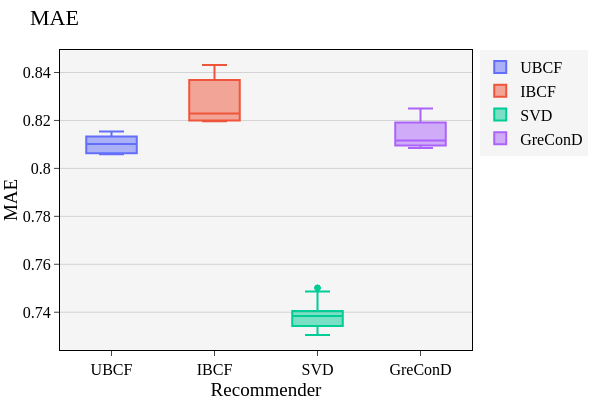

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        UBCF  0.810248            0.003734  0.000014  0.805946  0.815408  0.810201  0.806361  0.813324     0.795917     0.823768  0.108201 -1.590941
1        IBCF  0.828501            0.009655  0.000093  0.819683  0.843128  0.822856  0.819979  0.836862     0.794654     0.862187  0.495204 -1.550298
2         SVD  0.738702            0.006283  0.000039  0.730496  0.750193  0.738378  0.734278  0.740556     0.724861     0.749973  0.782277 -0.582148
3     GreConD  0.814753            0.006341  0.000040  0.808473  0.825014  0.811616  0.809530  0.819132     0.795127     0.833534  0.583128 -1.286343


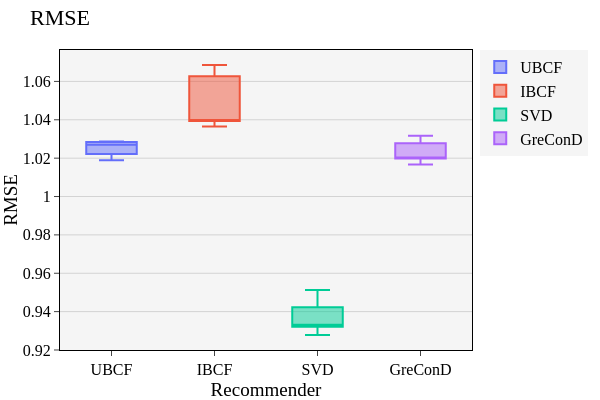

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        UBCF  1.025019            0.003869  0.000015  1.018906  1.028689  1.026925  1.022108  1.028469     1.012565     1.038012 -0.537917 -1.389219
1        IBCF  1.049317            0.013481  0.000182  1.036563  1.068561  1.039427  1.039353  1.062682     1.004360     1.097674  0.447512 -1.698562
2         SVD  0.937635            0.007911  0.000063  0.927814  0.951276  0.933153  0.932225  0.942306     0.917104     0.957427  0.740790 -0.956861
3     GreConD  1.023256            0.005550  0.000031  1.016699  1.031679  1.020335  1.019847  1.027718     1.008041     1.039523  0.398018 -1.421559


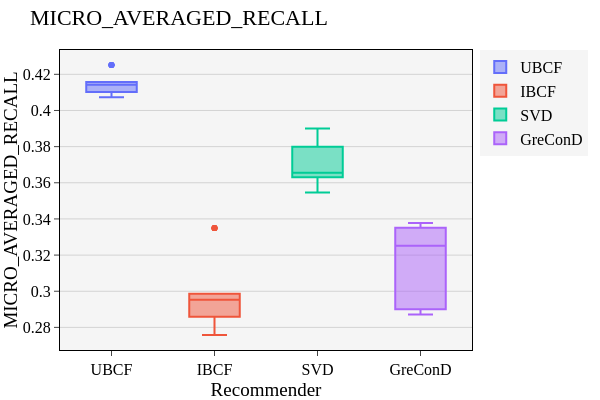

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        UBCF  0.414530            0.006094  0.000037  0.407299  0.425156  0.414291  0.410175  0.415728     0.401844     0.424059  0.654849 -0.701571
1        IBCF  0.298103            0.020055  0.000402  0.275790  0.334935  0.295322  0.285911  0.298557     0.266941     0.317526  0.917986 -0.390922
2         SVD  0.370323            0.009572  0.000092  0.354613  0.390031  0.365581  0.363045  0.379900     0.337762     0.405183  0.421411 -1.180270
3     GreConD  0.315052            0.022014  0.000485  0.287153  0.337732  0.325119  0.290076  0.335180     0.222419     0.402836 -0.308486 -1.778782


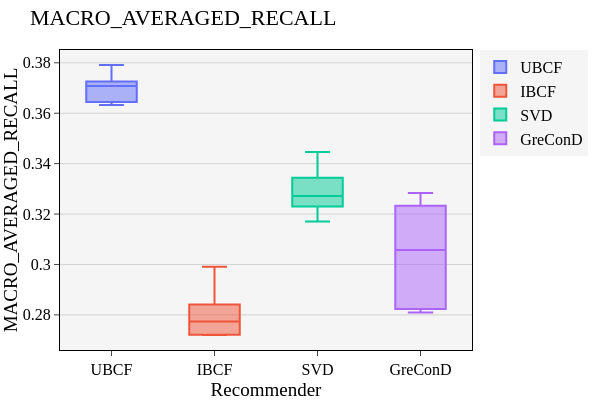

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        UBCF  0.370037            0.005779  0.000033  0.363243  0.379128  0.370770  0.364456  0.372588     0.352257     0.384787  0.291000 -1.211878
1        IBCF  0.280953            0.010108  0.000102  0.272020  0.299122  0.277370  0.272123  0.284133     0.254107     0.302148  0.887361 -0.668565
2         SVD  0.328855            0.006846  0.000047  0.317085  0.344630  0.327184  0.323025  0.334420     0.305933     0.351512  0.465447 -0.761973
3     GreConD  0.304143            0.019846  0.000394  0.280932  0.328359  0.305746  0.282365  0.323310     0.220947     0.384728 -0.040526 -1.718517


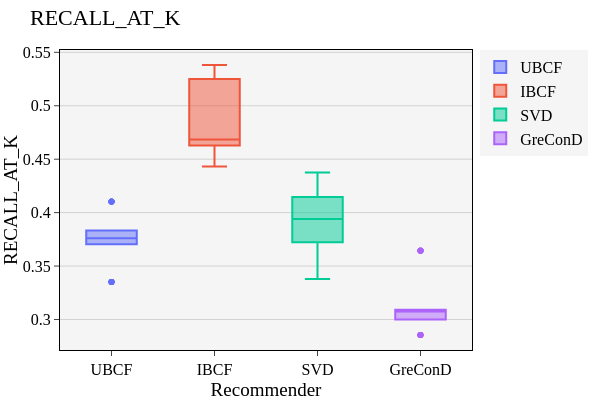

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        UBCF  0.375019            0.024214  0.000586  0.335097  0.410329  0.376109  0.370316  0.383244     0.350924     0.402637 -0.269768 -0.614760
1        IBCF  0.487490            0.037191  0.001383  0.443179  0.538132  0.468395  0.462713  0.525032     0.369236     0.618510  0.286177 -1.648511
2         SVD  0.391920            0.030505  0.000931  0.337792  0.437508  0.394013  0.372439  0.409665     0.316600     0.465504 -0.129262 -1.200914
3     GreConD  0.313286            0.026892  0.000723  0.285491  0.364412  0.307425  0.299936  0.309166     0.286091     0.323011  1.126197 -0.146371


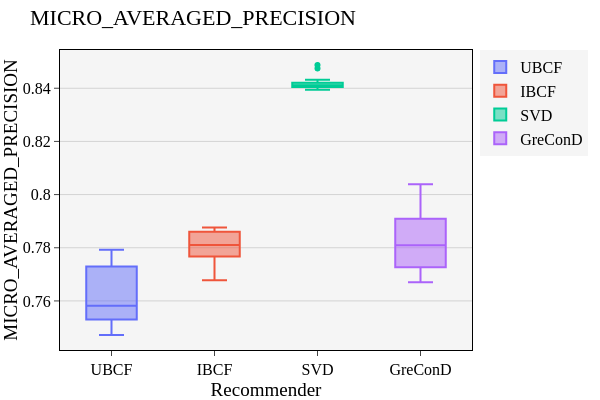

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        UBCF  0.762135            0.012104  0.000147  0.747185  0.779292  0.758209  0.753049  0.772939     0.723215     0.802773  0.243544 -1.534559
1        IBCF  0.779843            0.007156  0.000051  0.767774  0.787621  0.781029  0.776726  0.786066     0.762717     0.800076 -0.587013 -0.980224
2         SVD  0.841762            0.002169  0.000005  0.839410  0.848741  0.841153  0.840515  0.841848     0.838517     0.843846  1.880067  3.402113
3     GreConD  0.783098            0.013149  0.000173  0.767041  0.803897  0.780934  0.772698  0.790920     0.745364     0.818254  0.369600 -1.199614


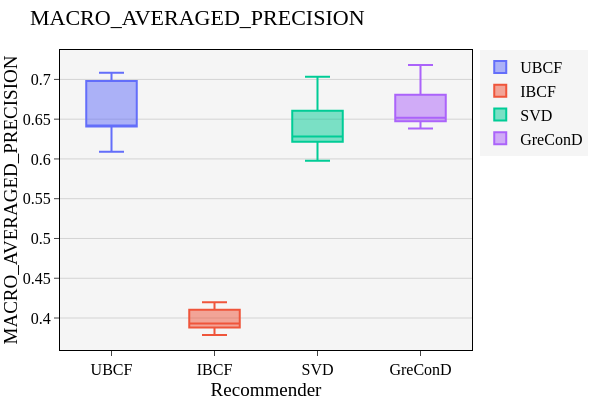

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        UBCF  0.659574            0.037619  0.001415  0.609072  0.708250  0.641626  0.640838  0.698083     0.554972     0.783949  0.117503 -1.547507
1        IBCF  0.397902            0.014989  0.000225  0.378627  0.419706  0.392995  0.387924  0.410259     0.354421     0.443762  0.236352 -1.423401
2         SVD  0.643866            0.031718  0.001006  0.597717  0.703307  0.628346  0.622249  0.659744     0.566007     0.715986  0.657749 -0.914747
3     GreConD  0.667264            0.029109  0.000847  0.638417  0.718112  0.651838  0.647254  0.680700     0.597085     0.730868  0.796338 -0.875330


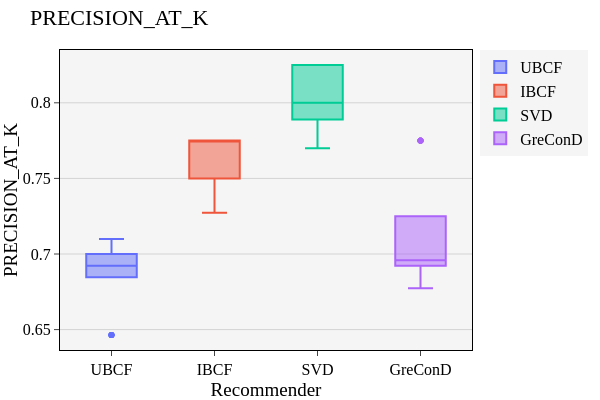

  Recommender      Mean  Standard Deviation  Variance       Min    Max    Median        Q1     Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        UBCF  0.686670            0.021805  0.000475  0.646429  0.710  0.692308  0.684615  0.700     0.661538     0.723077 -0.963192 -0.389084
1        IBCF  0.760455            0.019210  0.000369  0.727273  0.775  0.775000  0.750000  0.775     0.712500     0.812500 -0.802562 -1.004649
2         SVD  0.802089            0.020274  0.000411  0.770000  0.825  0.800000  0.788889  0.825     0.734722     0.879167 -0.225965 -1.380327
3     GreConD  0.713083            0.034604  0.001197  0.677273  0.775  0.695833  0.692308  0.725     0.643269     0.774038  0.864190 -0.679465


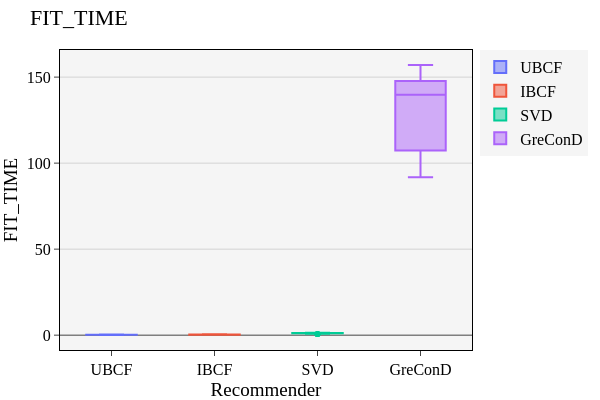

  Recommender        Mean  Standard Deviation    Variance        Min         Max      Median          Q1          Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        UBCF    0.220310            0.077175    0.005956   0.098127    0.437751    0.222239    0.172507    0.279050     0.012692     0.438864  0.598887  0.528125
1        IBCF    0.379536            0.079817    0.006371   0.266598    0.534796    0.354172    0.312114    0.428408     0.137672     0.602850  0.470017 -0.986074
2         SVD    1.120077            0.223976    0.050165   0.595603    1.436929    1.190144    1.078480    1.263011     0.801684     1.539807 -1.197063  0.466662
3     GreConD  130.536786           21.415624  458.628971  91.753315  157.036943  139.734885  108.374812  147.478919    49.718651   206.135080 -0.527432 -1.355970


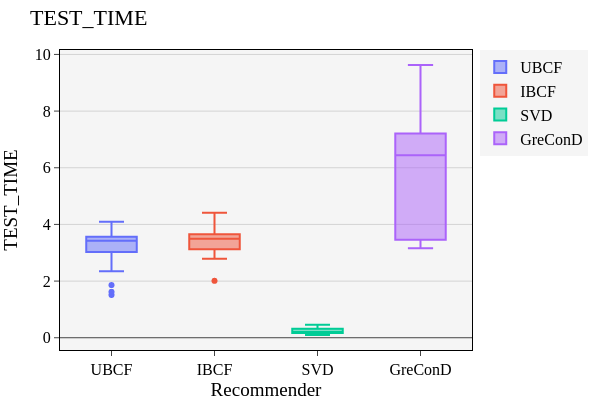

  Recommender      Mean  Standard Deviation  Variance       Min       Max    Median        Q1        Q3  Lower Fence  Upper Fence  Skewness  Kurtosis
0        UBCF  3.193223            0.656319  0.430755  1.509439  4.096614  3.423433  3.065641  3.558080     2.326983     4.296738 -1.436792  1.069760
1        IBCF  3.400839            0.466221  0.217362  2.009427  4.415099  3.496444  3.121013  3.646664     2.332537     4.435141 -0.631020  1.574533
2         SVD  0.229143            0.109378  0.011963  0.096800  0.462821  0.180071  0.165636  0.309460    -0.050100     0.525196  0.829089 -0.535525
3     GreConD  5.729203            2.124407  4.513104  3.156427  9.626980  6.441250  3.463454  7.165219    -2.089194    12.717866  0.123082 -1.444237


In [38]:
import pandas as pd
import scipy

import plotly.graph_objects as go

pd.set_option("display.expand_frame_repr", False)


def calculate_boxplot_values(data):
    # Calculate quartiles
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    # Calculate the upper fence and lower fence
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    return Q1, Q3, lower_fence, upper_fence


def plot_metric_box_plot(metric_name, concatenated_results):
    fig = go.Figure()
    for recommender_name, metric_results in concatenated_results.items():
        fig.add_trace(
            go.Box(
                y=metric_results[metric_name],
                name=recommender_name,
            )
        )

    fig.update_layout(
        title=f"{metric_name.upper()}",
        yaxis_title=metric_name.upper(),
        xaxis_title="Recommender",
        width=600,
        height=400,
        margin_l=60,
    )

    fig.show()


def get_result_table(metric_name, concatenated_results):
    results = []
    for recommender_name, metric_results in concatenated_results.items():
        metric_data = metric_results[metric_name]
        mean = np.mean(metric_data)
        median = np.median(metric_data)
        standard_deviation = np.std(metric_data)
        variance = np.var(metric_data)
        skewness = scipy.stats.skew(metric_data)
        kurtosis = scipy.stats.kurtosis(metric_data)
        min_val = np.min(metric_data)
        max_val = np.max(metric_data)
        Q1, Q3, lower_fence, upper_fence = calculate_boxplot_values(metric_data)

        results.append(
            {
                "Recommender": recommender_name,
                "Mean": mean,
                "Standard Deviation": standard_deviation,
                "Variance": variance,
                "Min": min_val,
                "Max": max_val,
                "Median": median,
                "Q1": Q1,
                "Q3": Q3,
                "Lower Fence": lower_fence,
                "Upper Fence": upper_fence,
                "Skewness": skewness,
                "Kurtosis": kurtosis,
            }
        )

    return pd.DataFrame(results)


def get_latex_table_from_pandas_table(pandas_table):
    return pandas_table.to_latex(index=False, float_format="%.3f")


for metric_name in METRIC_NAMES:
    plot_metric_box_plot(metric_name, concatenated_results)
    print(get_result_table(metric_name, concatenated_results))

In [56]:
from dataset.random_dataset import RandomDataset
from surprise.model_selection import KFold

# Experiment parameters
NUMBERS_OF_ITEMS = [100, 200, 300]
NUMBER_OF_USERS = 1000
RATING_SCALE = 5
SPARSITY_TARGET = 0.1

experiment_results = {}

for number_of_items in NUMBERS_OF_ITEMS:
    print(f"Number of items: {number_of_items}")
    dataset = RandomDataset(NUMBER_OF_USERS, number_of_items, RATING_SCALE, SPARSITY_TARGET)

    kf = KFold(n_splits=5)
    folds = [(index, fold) for index, fold in enumerate(kf.split(dataset))]

    raw_results = benchmark(folds, recommenders)
    coalesced_results = coalesce_fold_results(raw_results)
    concatenated_results = concatenate_fold_results(coalesced_results)

    experiment_results[number_of_items] = concatenated_results


Number of items: 100
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:03,412 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:03,633 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:03,887 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:04,108 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:04,333 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:04,463 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:04,464 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...


2023-11-09 11:37:04,575 - recommenders - INFO - Generating Formal Context...


Done computing similarity matrix.


2023-11-09 11:37:04,661 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:04,662 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


2023-11-09 11:37:04,910 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:04,910 - recommenders - INFO - Generating Similarity Matrix...


Done computing similarity matrix.


2023-11-09 11:37:04,905 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


2023-11-09 11:37:05,159 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:05,160 - recommenders - INFO - Generating Similarity Matrix...


Done computing similarity matrix.


2023-11-09 11:37:05,188 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


2023-11-09 11:37:05,401 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:05,403 - recommenders - INFO - Generating Similarity Matrix...


Done computing similarity matrix.


2023-11-09 11:37:05,439 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


2023-11-09 11:37:05,666 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:05,670 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:05,670 - recommenders - INFO - Generating Similarity Matrix...


Done computing similarity matrix.


2023-11-09 11:37:05,900 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:06,159 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:06,160 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:06,186 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...


2023-11-09 11:37:06,477 - recommenders - INFO - Generating Formal Context...


Done computing similarity matrix.
Computing the cosine similarity matrix...


2023-11-09 11:37:06,540 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:06,525 - recommenders - INFO - Generating Similarity Matrix OK


Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.

2023-11-09 11:37:06,750 - recommenders - INFO - Generating Formal Context OK


Done computing similarity matrix.



2023-11-09 11:37:06,767 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:06,809 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:06,827 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:07,007 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:07,330 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:07,342 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:07,349 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:07,341 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:07,366 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.Done computing similarity matrix.

Computing the cosine similarity matrix...


2023-11-09 11:37:07,602 - recommenders - INFO - Generating Formal Context...


Done computing similarity matrix.


2023-11-09 11:37:07,701 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:07,704 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:07,705 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:07,705 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:07,978 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:07,962 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:07,979 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:08,226 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:08,239 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:08,286 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:08,350 - recommenders - INFO - Generating Similarity Matrix OK


Done computing similarity matrix.

2023-11-09 11:37:08,404 - recommenders - INFO - Generating Formal Context OK


2023-11-09 11:37:08,407 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:08,474 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:08,553 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:08,557 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:08,587 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:08,617 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:08,645 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:08,645 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:08,654 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


2023-11-09 11:37:08,806 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:08,829 - recommenders - INFO - Generating Similarity Matrix...


Done computing similarity matrix.


2023-11-09 11:37:09,003 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:09,016 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...


2023-11-09 11:37:09,079 - recommenders - INFO - Generating Formal Context OK


Done computing similarity matrix.

2023-11-09 11:37:09,086 - recommenders - INFO - Generating Similarity Matrix...


2023-11-09 11:37:09,113 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:09,121 - recommenders - INFO - Generating Formal Context OK


Computing the cosine similarity matrix...

2023-11-09 11:37:09,149 - recommenders - INFO - Generating Similarity Matrix...



Done computing similarity matrix.


2023-11-09 11:37:09,261 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...

2023-11-09 11:37:09,354 - recommenders - INFO - Generating Similarity Matrix OK



Done computing similarity matrix.


2023-11-09 11:37:09,375 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...


2023-11-09 11:37:09,487 - recommenders - INFO - Generating Similarity Matrix OK


Done computing similarity matrix.


2023-11-09 11:37:09,523 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:09,628 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:09,631 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:09,674 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:09,822 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:09,823 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:09,846 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:09,901 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:09,908 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:09,909 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


2023-11-09 11:37:10,043 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:10,060 - recommenders - INFO - Generating Similarity Matrix OK


Done computing similarity matrix.


2023-11-09 11:37:10,093 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:10,203 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:10,333 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:10,415 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:10,416 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:10,624 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:10,703 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:10,819 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:10,856 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:10,891 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:10,892 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:10,900 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:11,065 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:11,093 - recommenders - INFO - Generating Similarity Matrix OK


Number of items: 200
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:12,002 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:12,233 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:12,477 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...


2023-11-09 11:37:12,799 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.


2023-11-09 11:37:13,105 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Computing the cosine similarity matrix...


2023-11-09 11:37:13,309 - recommenders - INFO - Generating Formal Context...


Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...


2023-11-09 11:37:13,557 - recommenders - INFO - Generating Formal Context...


Done computing similarity matrix.


2023-11-09 11:37:13,615 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:13,615 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:13,857 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:13,858 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:14,069 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:14,171 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:14,408 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:14,409 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:14,549 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:14,614 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:14,615 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:14,883 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...Computing the cosine similarity matrix...

Done computing similarity matrix.
Done computing similarity matrix.


2023-11-09 11:37:15,187 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Computing the cosine similarity matrix...Done computing similarity matrix.

Done computing similarity matrix.


2023-11-09 11:37:15,475 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:15,589 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...


2023-11-09 11:37:15,767 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:15,768 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:15,810 - recommenders - INFO - Generating Formal Context OK


Done computing similarity matrix.

2023-11-09 11:37:15,822 - recommenders - INFO - Generating Similarity Matrix...


2023-11-09 11:37:15,910 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:15,912 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:15,940 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:16,084 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...Computing the cosine similarity matrix...

Done computing similarity matrix.
Done computing similarity matrix.


2023-11-09 11:37:16,562 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:16,861 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:16,862 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:16,909 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...


2023-11-09 11:37:17,030 - recommenders - INFO - Generating Similarity Matrix OK


Done computing similarity matrix.


2023-11-09 11:37:17,310 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:17,321 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:17,745 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:17,913 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:17,914 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...


2023-11-09 11:37:18,022 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:18,027 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:18,012 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:18,077 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:18,097 - recommenders - INFO - Generating Similarity Matrix...


Done computing similarity matrix.


2023-11-09 11:37:18,346 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:18,347 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:18,455 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:18,561 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:18,813 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...

2023-11-09 11:37:18,851 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:18,861 - recommenders - INFO - Generating Similarity Matrix...



Done computing similarity matrix.


2023-11-09 11:37:18,931 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:19,187 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:19,391 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:19,684 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:19,687 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:19,781 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:19,807 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:19,949 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:20,001 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:20,008 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:20,012 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


2023-11-09 11:37:20,154 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:20,167 - recommenders - INFO - Generating Similarity Matrix...


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:20,496 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:20,567 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:20,568 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:20,570 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...


2023-11-09 11:37:20,653 - recommenders - INFO - Generating Similarity Matrix OK


Done computing similarity matrix.


2023-11-09 11:37:20,663 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:20,784 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:20,889 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:20,934 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:21,018 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:21,106 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:21,450 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:21,462 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:21,481 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:21,752 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:21,803 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:21,909 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:22,067 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:22,148 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:22,311 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:22,312 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:22,328 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:22,646 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:22,771 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:22,772 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:22,820 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:22,821 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:22,910 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:22,911 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:23,046 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:23,047 - recommenders - INFO - Generat

Number of items: 300
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:24,533 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:24,875 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:25,264 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:25,511 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.


2023-11-09 11:37:25,911 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...


2023-11-09 11:37:25,982 - recommenders - INFO - Generating Formal Context...


Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:26,208 - recommenders - INFO - Generating Formal Context...


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:26,667 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:27,006 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...Done computing similarity matrix.

Done computing similarity matrix.
Computing the cosine similarity matrix...


2023-11-09 11:37:27,478 - recommenders - INFO - Generating Formal Context...


Done computing similarity matrix.Computing the cosine similarity matrix...

Done computing similarity matrix.


2023-11-09 11:37:27,773 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:27,774 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:27,777 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:28,063 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:28,312 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the cosine similarity matrix...


2023-11-09 11:37:28,828 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:28,838 - recommenders - INFO - Generating Similarity Matrix...


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:29,208 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:30,000 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:30,035 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:30,037 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:30,116 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:30,120 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:30,162 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:30,164 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...


2023-11-09 11:37:30,267 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:30,294 - recommenders - INFO - Generating Similarity Matrix...


Done computing similarity matrix.


2023-11-09 11:37:30,869 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:31,344 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:31,367 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:31,718 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:31,737 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:31,829 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:31,830 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:32,036 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:32,284 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:32,382 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:32,397 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:32,603 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:32,606 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...


2023-11-09 11:37:32,738 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:32,760 - recommenders - INFO - Generating Similarity Matrix...


Done computing similarity matrix.


2023-11-09 11:37:32,876 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:33,002 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:33,229 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:33,296 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:33,616 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:33,641 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:33,780 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:33,801 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...


2023-11-09 11:37:34,150 - recommenders - INFO - Generating Similarity Matrix OK


Done computing similarity matrix.


2023-11-09 11:37:34,473 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:34,507 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:34,648 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...
Done computing similarity matrix.Computing the cosine similarity matrix...

Done computing similarity matrix.


2023-11-09 11:37:35,072 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:35,092 - recommenders - INFO - Generating Similarity Matrix OK


Computing the cosine similarity matrix...


2023-11-09 11:37:35,418 - recommenders - INFO - Generating Formal Context...


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:35,701 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:35,905 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:36,105 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...


2023-11-09 11:37:36,231 - recommenders - INFO - Generating Similarity Matrix OK


Done computing similarity matrix.


2023-11-09 11:37:36,282 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:36,283 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:36,648 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...


2023-11-09 11:37:36,651 - recommenders - INFO - Generating Similarity Matrix OK


Done computing similarity matrix.


2023-11-09 11:37:36,900 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:37,187 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.

2023-11-09 11:37:37,606 - recommenders - INFO - Generating Formal Context OK



Done computing similarity matrix.

2023-11-09 11:37:37,633 - recommenders - INFO - Generating Similarity Matrix...


2023-11-09 11:37:37,939 - recommenders - INFO - Generating Formal Context...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:38,198 - recommenders - INFO - Generating Formal Context...
2023-11-09 11:37:38,240 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:38,240 - recommenders - INFO - Generating Similarity Matrix...


Computing the cosine similarity matrix...
Done computing similarity matrix.


2023-11-09 11:37:38,417 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:38,418 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:38,442 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:38,445 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:38,831 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:38,883 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:38,886 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:38,927 - recommenders - INFO - Generating Similarity Matrix OK
2023-11-09 11:37:39,771 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:39,772 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:39,902 - recommenders - INFO - Generating Formal Context OK
2023-11-09 11:37:39,903 - recommenders - INFO - Generating Similarity Matrix...
2023-11-09 11:37:40,164 - recommenders - INFO - Gene

In [57]:
def get_result_table(experiment_results) -> pd.DataFrame:
    """
    Get a Pandas DataFrame with the results of the experiment.

    Args:
        all_results: Dictionary that maps recommender names to metrics to folds to lists of results.

    Returns:
        Pandas DataFrame with the results of the experiment.

    """
    column_recommender = []
    column_fold = []
    column_metric = []
    column_value = []

    for number_of_items, concatenated_results in experiment_results.items():
        for recommender_name, metric_results in concatenated_results.items():
            for metric_name, fold_results in metric_results.items():
                for fold, results in fold_results.items():
                    for result in results:
                        column_recommender.append(recommender_name)
                        column_fold.append(fold)
                        column_metric.append(metric_name)
                        column_value.append(result)

    data = {
        "Recommender": column_recommender,
        "Fold": column_fold,
        "Metric": column_metric,
        "Value": column_value,
    }

    return pd.DataFrame(data)


print(get_result_table(experiment_results))

AttributeError: 'list' object has no attribute 'items'

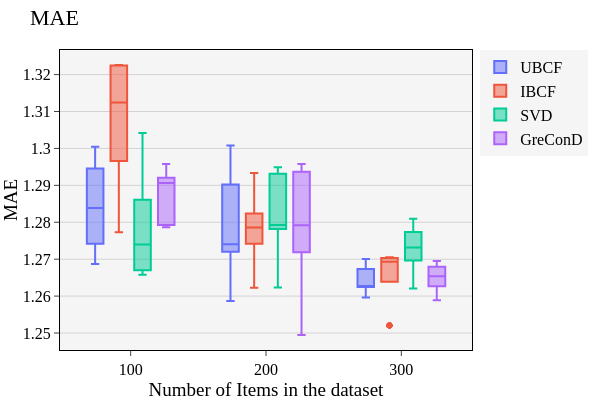

In [64]:
RECOMMENDER_TO_COLOR_MAP = {
    "UBCF": "rgb(255, 127, 14)",
    "IBCF": "rgb(44, 160, 44)",
    "SVD": "rgb(31, 119, 180)",
    'GreConD': "rgb(214, 39, 40)",
}


def plot_continous_box_plot(metric_name, all_results):
    fig = go.Figure()

    structured_results = defaultdict(lambda: defaultdict(list))

    for number_of_items, concatenated_results in all_results.items():
        for recommender_name, metric_results in concatenated_results.items():
            x = [number_of_items] * len(metric_results[metric_name])
            structured_results[recommender_name]["x_axis"] += x
            structured_results[recommender_name]["y_axis"] += metric_results[metric_name]

    for recommender_name, metric_results in structured_results.items():
        fig.add_trace(
            go.Box(
                x=metric_results["x_axis"],
                y=metric_results["y_axis"],
                name=recommender_name,
            )
        )

    structured_results = defaultdict(lambda: defaultdict(list))

    fig.update_layout(
        title=f"{metric_name.upper()}",
        yaxis_title=metric_name.upper(),
        xaxis_title="Number of Items in the dataset",
        width=600,
        height=400,
        margin_l=60,
        boxmode="group",
    )

    fig.show()


def filter_results_by_recommender(results, recommender_name, invert=False):
    filtered_results = {}
    for number_of_items, concatenated_results in results.items():
        filtered_results[number_of_items] = {}
        for recommender_name_, metric_results in concatenated_results.items():
            if invert:
                if recommender_name_ != recommender_name:
                    filtered_results[number_of_items][recommender_name_] = metric_results
            else:
                if recommender_name_ == recommender_name:
                    filtered_results[number_of_items][recommender_name_] = metric_results
    return filtered_results

plot_continous_box_plot("fit_time", filter_results_by_recommender(experiment_results, "GreConD", True))